In [1]:
!pip install -q -U transformers num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 14.6 MB/s eta 0:00:00


# Library code, modified

MQT Q-Former from https://github.com/gordonhu608/MQT-LLaVA

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.init import trunc_normal_
import math
from functools import partial
import numpy as np
import random

def get_matry_n(num_visual_tokens):
    if num_visual_tokens == 'first_stage':
        return 729
    elif num_visual_tokens == 'second_stage':
        matry_list = range(1, 730, 4)
        return random.choice(matry_list)

    try:
        num_visual_tokens = int(num_visual_tokens)
        if 1 <= num_visual_tokens <= 729:
            return num_visual_tokens
    except (ValueError, TypeError):
        print('The num_visual_tokens is should be an integer between 1 and 729')

    raise ValueError(f"Invalid input: {num_visual_tokens}")

def get_abs_pos(abs_pos, tgt_size):
    # abs_pos: L, C
    # tgt_size: (H, W)
    # return: M, C
    src_size = int(math.sqrt(abs_pos.size(0)))
    # tgt_size = int(math.sqrt(tgt_size))
    dtype = abs_pos.dtype
    return F.interpolate(
        abs_pos.float().reshape(1, src_size, src_size, -1).permute(0, 3, 1, 2),
        size=(tgt_size[0], tgt_size[1]),
        mode="bicubic",
        align_corners=False,
    ).permute(0, 2, 3, 1).flatten(0, 2).to(dtype=dtype)


# https://github.com/facebookresearch/mae/blob/efb2a8062c206524e35e47d04501ed4f544c0ae8/util/pos_embed.py#L20
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])


    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


class Resampler(nn.Module):
    """
    A 2D perceiver-resampler network with one cross attention layers by
        (grid_size**2) learnable queries and 2d sincos pos_emb
    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self.num_queries = grid_size ** 2
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.pos_embed = nn.Parameter(
            torch.from_numpy(get_2d_sincos_pos_embed(kv_dim, grid_size)).half()
        ).requires_grad_(False)

        self.query = nn.Parameter(torch.zeros(self.num_queries, kv_dim)).to(torch.float32)
        trunc_normal_(self.query, std=.02)

        self.attn = nn.MultiheadAttention(kv_dim, num_heads).to(device = "cuda:0", dtype=torch.float32)

        self.ln_q = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)
        self.ln_k = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)
        self.ln_v = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)

        # self.ln_post = norm_layer(kv_dim)
        self.proj = nn.Parameter((embed_dim ** -0.5) * torch.randn(kv_dim, embed_dim)).to(device="cuda:0")

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, num_visual_tokens=256, tgt_size=(24,24), attn_mask=None):
        pos_embed = get_abs_pos(self.pos_embed, tgt_size)

        x = x.permute(1, 0, 2)  # x: (seq_len, batch_size, dim)
        B = x.shape[1]  # true batch size


        matry_n = get_matry_n(num_visual_tokens)
        q = self.query[:matry_n]  # (matry_n, dim)
        q = self._repeat(q, B)    # (matry_n, B, dim)

        k = self._repeat(pos_embed, B).to(device = "cuda:0", dtype=torch.float32)
        v = x
        q= q.to(device = "cuda:0")
        # self.pos_embed = self.pos_embed.to(device = "cuda:0")

        q = self.ln_q(q + self.pos_embed[:matry_n].unsqueeze(1).to(device = "cuda:0")).to(device = x.device ,dtype=torch.float32)
        k = self.ln_k(k).to(device = x.device ,dtype=torch.float32)
        v = self.ln_v(v).to(device = x.device ,dtype=torch.float32)

        out = self.attn(q, k, v, attn_mask=attn_mask)[0]  # (matry_n, B, dim)


        x = out.permute(1, 0, 2)

        x = x @ self.proj
        # print(x.shape)
        return x

    def _repeat(self, query, N: int):
        return query.unsqueeze(1).repeat(1, N, 1)

In [2]:
class MultiResampler(nn.Module):
    """
    experimental multi-resampler

    Args:
        num_resamplers:int = number of resamplers(qformers)

    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            num_resamplers,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.resamplers = [Resampler(grid_size, embed_dim, num_heads, kv_dim, norm_layer) for _ in range(num_resamplers)]

    def _init_weights(self, m):
        for i in  range(len(self.resamplers)):
            self.resamplers[i]._init_weights(m)

    def forward(self, x, num_visual_tokens=256, tgt_size=(27,27), attn_mask=None):
        # raise NotImplementedError()
        # x should be a list
        assert len(x) == len(self.resamplers)

        num_vt_each = num_visual_tokens//len(self.resamplers)
        outs = []
        for i in range(len(self.resamplers)):
            outs.append(self.resamplers[i].forward(x[i], num_vt_each, tgt_size))
        concat = torch.cat(outs, dim=1)
        return concat

# Load Model

In [3]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words

model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
model.config

SmolVLMConfig {
  "architectures": [
    "SmolVLMForConditionalGeneration"
  ],
  "image_token_id": 49190,
  "model_type": "smolvlm",
  "pad_token_id": 128002,
  "scale_factor": 3,
  "text_config": {
    "_flash_attn_2_enabled": true,
    "_name_or_path": "None",
    "architectures": [
      "VLlama3ForCausalLM"
    ],
    "attention_bias": false,
    "attention_dropout": 0.0,
    "head_dim": 64,
    "hidden_act": "silu",
    "hidden_size": 2048,
    "initializer_range": 0.02,
    "intermediate_size": 8192,
    "max_position_embeddings": 8192,
    "mlp_bias": false,
    "model_type": "llama",
    "neftune_noise_alpha": 0.0,
    "num_attention_heads": 32,
    "num_hidden_layers": 24,
    "num_key_value_heads": 32,
    "pad_token_id": 2,
    "perceiver_config": {
      "_attn_implementation_autoset": false,
      "_name_or_path": "",
      "add_cross_attention": false,
      "architectures": null,
      "attention_dropout": 0.0,
      "bad_words_ids": null,
      "begin_suppress_tokens":

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

2246784880

In [ ]:
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

412987248

In [ ]:
# conversation = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "url": "sample.png"},
#             {"type": "text", "text": "Describe this image."}
#         ]
#     }
# ]

# inputs = processor.apply_chat_template(
#     conversation,
#     add_generation_prompt=True,
#     tokenize=True,
#     return_dict=True,
#     return_tensors="pt"
# ).to(model.device, dtype=torch.bfloat16)

# output_ids = model.generate(**inputs, max_new_tokens=128)
# generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)

In [ ]:
generated_texts

# Q-Former

In [4]:
qformer_config = {
    "grid_size": 27,
    "embed_dim": 1152,
    "num_heads": 16,
    "num_resamplers": 4,
    "kv_dim": 1152
}

In [34]:
import torch
import torch.nn as nn
from transformers import ViTModel, AutoImageProcessor
from transformers.modeling_outputs import BaseModelOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from torchvision.transforms import functional as F_transforms

class MultiCropVisionEncoder(nn.Module):
    def __init__(self, qformer_config, vision_tower):
        super().__init__()
        self.num_resamplers = qformer_config["num_resamplers"]
        self.embed_dim = qformer_config["embed_dim"]
        self.grid_size = qformer_config["grid_size"]

        self.vision_tower = vision_tower
        vision_hidden_size = self.vision_tower.config.hidden_size
        self.vision_tower_image_size = self.vision_tower.config.image_size

        self.vision_proj = nn.Linear(vision_hidden_size, self.embed_dim)

        self.multi_resampler = MultiResampler(
            grid_size=qformer_config["grid_size"],
            embed_dim=qformer_config["embed_dim"],
            num_heads=qformer_config["num_heads"],
            num_resamplers=qformer_config["num_resamplers"],
            kv_dim=qformer_config["kv_dim"],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )

    def forward(self, pixel_values, patch_attention_mask=None):
        pixel_values = pixel_values.to(torch.float32)
        b4, c, h, w = pixel_values.shape
        assert b4 % self.num_resamplers == 0, "Batch size must be divisible by number of resamplers"
        batch_size = b4 // self.num_resamplers

        image = np.transpose(pixel_values[0].cpu().numpy(), (1, 2, 0))
        plt.imshow(image / 255.0)
        plt.show()

        patch_embeddings_list = []
        for i in range(self.num_resamplers):
            start = i * batch_size
            end = (i + 1) * batch_size
            sub_batch = pixel_values[start:end]

            resized_sub_batch = F_transforms.resize(sub_batch, size=(432, 432))


            vision_outputs = self.vision_tower(pixel_values=resized_sub_batch, interpolate_pos_encoding=True)
            embeddings = vision_outputs.last_hidden_state

            embeddings = embeddings[:, 1:, :]
            embeddings = self.vision_proj(embeddings)

            patch_embeddings_list.append(embeddings)

        patch_embeddings = torch.stack(patch_embeddings_list, dim=1)

        # print(patch_embeddings.shape)
        x_list = list(patch_embeddings.unbind(dim=1))
        out = self.multi_resampler(x_list, num_visual_tokens=self.grid_size**2 * self.num_resamplers)

        out = out.view(batch_size * self.num_resamplers, self.grid_size**2, self.embed_dim).to(
            device=pixel_values.device,
            dtype=torch.bfloat16
        )
        # print(out.shape)
        return BaseModelOutput(last_hidden_state=out)

In [35]:
vision_tower = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [26]:
vision_tower.config.hidden_size

768

In [32]:
test_vm = MultiCropVisionEncoder(qformer_config, vision_tower)
test_vm = test_vm.to(device= "cuda:0", dtype=torch.float32)

In [36]:
sum(p.numel() for p in test_vm.parameters() if p.requires_grad)

87275136

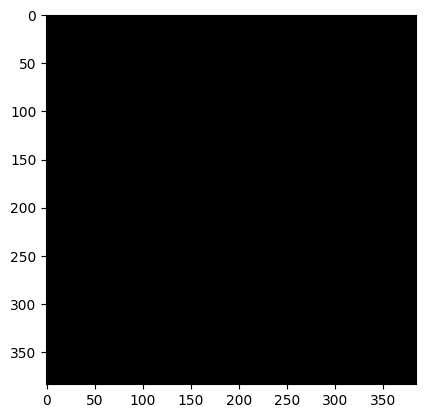

torch.Size([1, 4, 729, 1152])
torch.Size([4, 729, 1152])
torch.Size([4, 729, 1152])


In [33]:
dummy_image = torch.randn(4, 3, 384, 384).to(device="cuda:0", dtype=torch.float32)
output = test_vm(dummy_image)
print(output.last_hidden_state.shape)

# Integration

## loading the test image

In [38]:
from PIL import Image
image = Image.open("sample.png")

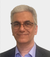

In [39]:
base_width = 50
w_percent = (base_width / float(image.size[0]))
h_size = int((float(image.size[1]) * float(w_percent)))
resized_image = image.resize((base_width, h_size), Image.Resampling.LANCZOS)

display(resized_image)

## modifying model config to support new vision model

In [ ]:
qformer_config

{'grid_size': 27,
 'embed_dim': 1152,
 'num_heads': 16,
 'num_resamplers': 4,
 'kv_dim': 1152}

In [37]:
old_config = model.config.vision_config

In [ ]:
old_config

SmolVLMVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 1152,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4304,
  "layer_norm_eps": 1e-06,
  "max_image_size": {
    "longest_edge": 384
  },
  "model_type": "smolvlm_vision",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 27,
  "patch_size": 14,
  "size": {
    "longest_edge": 1920
  },
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.55.0",
  "use_base_siglip": false
}

In [40]:
class Config:
    def __init__(self, dictionary, old_config):
        for key, value in old_config.items():
            setattr(self, key, value)
        for key, value in dictionary.items():
            setattr(self, key, value)

qformer_config_obj = Config(qformer_config, old_config.get_config_dict(model_path)[0]["vision_config"])

## swapping vision model

the commented codes below are used to check the inner dimensions of the original and new model. not removed in case further debugging is needed.

In [ ]:
old_vision_model = model.model.vision_model

In [ ]:
model.model.vision_model = None

In [41]:
model.model.vision_model = test_vm
model.config.vision_config = qformer_config_obj

In [42]:
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

87275136

In [ ]:
# dummy = torch.randn(1, 3, 384,384).to(device="cpu", dtype=torch.bfloat16)
# old_vision_model = old_vision_model.to("cpu")
# old_vision_model(dummy).last_hidden_state.shape

torch.Size([1, 729, 1152])

In [43]:
processor.image_processor.max_image_size["longest_edge"]= 384

In [44]:
processor.image_processor.do_image_splitting=False
processor.image_processor.do_resize=True

## testing new model inference for errors

In [ ]:
model.device

device(type='cuda', index=0)

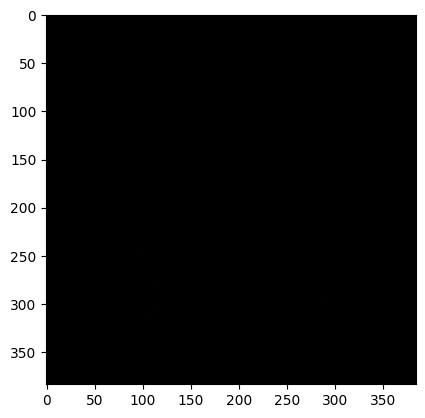

torch.Size([1, 4, 729, 1152])
torch.Size([4, 729, 1152])


['User:describe this image.\nAssistant:']

In [45]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=32)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

In [ ]:
model.model.vision_model

MultiCropVisionEncoder(
  (patch_embed): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14))
  (multi_resampler): MultiResampler()
)

# Save in huggingface